# CAB420, Practical 2 - Template

**Note, as the three questions in this weeks practical build on one another, all solutions are in the one script**

## Problem 1. Overfitting Linear Regression
In the week 1 practical, you developed a model to predict cyclist counts at a single counter. Using the same data and starting from the initial model before terms were removed, overcomplicate it such that it overfits to the training data. The easiest way to do this is by including a large number of higher order (i.e. interaction, quadratic and higher order polynomial) terms.

Verify that the model has overfit through evaluating on the validation and testing datasets, and compare it's performance to the simple model that you started with.

## Problem 2. Ridge Regression
Apply ridge regression to your two models (the simple model from Week 1, and the overfitting model from Problem 1 of this week). Using the validation set, select the best value of $\lambda$ for each model. For the selected model:
* Compute the $R^2$ and adjusted $R^2$, and draw a qqplot to assess the models validity;
* Compute the RMSE on the test set and compare the performance with the linear models.

## Problem 3. Lasso Regression
Apply lasso regression to your two models (the simple model from Week 1, and the overfitting model from Problem 1 of this week). Using the validation set, select the best value of $\lambda$ for each model. For the selected model:
* Compute the $R^2$ and adjusted $R^2$ (make sure to consider how many terms are removed by lasso), and draw a qqplot to assess the models validity;
* Compute the RMSE on the test set and compare the performance with the linear models and the ridge regression models.

### Relevant Examples

The second linear regression example, ``CAB420_Regression_Example_2_Regularised_Regression.ipynb`` is a useful starting point here. You may also find the third linear regression example, ``CAB420_Regression_Example_3_Regression_with_Less_Data.ipynb`` of use, however this contains the same relvant code (fitting linear and regularised regression).

### Suggested Packages

The following packages are suggested, however there are many ways to approach things in python, if you'd rather use different pacakges that's cool too.

In particular with this pratical, you have a choice of whether you'd rather use sklearn or statsmodels for regression.

In [1]:
# import all the important packages

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn, because of excellent heatmaps
import seaborn as sns;
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
# can also use sklearn for our regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

### Step 1: Load and Pre-process the data

Loading and pre-processing should follow the same process as the previous practical. This should:
* load the data
* split into train, validation and test and pull out X and Y arrays

In this practical we also seek to overcomplicate our model, i.e. add higher order terms, etc, such that it overfits. To achieve this you could:
* Use ``PolynomialFeatures`` which has been imported from ``sklearn.preprocessing``; or
* Use the x2fx function below which replicates a similar function is MATLAB and provides a handy way of adding higher order terms.

Maintain the original (unexpanded) copy of the data as a separate variable as well as the "blown up" version.

You should also consider the issue of data standardisation. This will be useful for the regularised regression and should be done prior to Questions 2 and 3; but you may also wish to do this here such that you are using the same data throughout. A function for standardisation is provided below.

In [2]:
def x2fx(x, model='quadratic'):
  """Will create a quadratic, interaction and linear
  versions of our variable of interest

  Similar to the `x2fx()` function in Matlab.

  Written by Saullo G. P. Castro, from
  https://stackoverflow.com/questions/26574998/is-there-an-equivalent-function-for-x2fx-in-numpy

  Basically don't worry too much about how this func works. If I had to write it myself,
  it would look a lot worse than this.

  Args:
    x (np.array):
      Data set with columns as features (variables) that we 
      want to generate higher order terms for
    model (str):
      Determine linear, interaction, quadratic, purequadratic terms
 
  Returns:
    Array with higher order terms added as additional columns
  """
  from itertools import combinations as comb
  linear = np.c_[np.ones(x.shape[0]), x]
  if model == 'linear':
    return linear
  if model == 'purequadratic':
    return np.c_[linear, x**2]

  interaction = np.vstack([x[:,i]*x[:,j] for i, j in
                           comb(range(x.shape[1]), 2)]).T
    
  if model == 'interaction':
    return np.c_[linear, interaction]
  if model == 'quadratic':
    return np.c_[linear, interaction, x**2]

def standardise(data, mu = None, sigma = None):
  """ Standardise/Normalise data to have zero mean and unit variance

  Args:
    data (np.array):
      data we want to standardise (usually covariates)

    Returns:
      Standardised data, mean of data, standard deviation of data
  """
  if (mu is None):
    mu = np.mean(data, axis=0)
  if (sigma is None):
    sigma = np.std(data, axis=0)
        
  scaled = (data - mu) / sigma
  return scaled, mu, sigma

In [3]:
data = pd.read_csv('../Prac01_Week1/combined.csv')
data.replace(0, np.nan, inplace=True)
filtered_data = data.dropna(thresh=1425, axis=1).dropna(axis=0)
print(filtered_data.columns)
repsonse = 'Bicenntenial Bikeway'
predictors = ['Maximum temperature (Degree C)', 'Daily global solar exposure (MJ/m*m)', 'Schulz Canal Bridge Cyclists Outbound', \
              'Story Bridge West Pedestrian Outbound', 'Bicentennial Bikeway Pedestrians Inbound', 'Story Bridge West Pedestrian Inbound', \
              'Bicentennial Bikeway Cyclists Inbound', 'Schulz Canal Bridge Pedestrians Inbound', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound']
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])

#train = filtered_data[filtered_data['Date'].dt.year < 2017]
#val = filtered_data[filtered_data['Date'].dt.year == 2017]
#test = filtered_data[filtered_data['Date'].dt.year > 2017]
from sklearn.model_selection import train_test_split

train, the_rest = train_test_split(filtered_data, train_size=0.3, random_state=42)
val, test = train_test_split(the_rest, train_size = 0.5, random_state = 24)
print(train.shape)
print(val.shape)
print(test.shape)

X_train = train[predictors].to_numpy()
X_val = val[predictors].to_numpy()
X_test = test[predictors].to_numpy()
y_train = train[repsonse].to_numpy()
y_val = val[repsonse].to_numpy()
y_test = test[repsonse].to_numpy()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

Index(['Unnamed: 0', 'Date', 'Maximum temperature (Degree C)',
       'Daily global solar exposure (MJ/m*m)',
       'Schulz Canal Bridge Cyclists Outbound',
       'Story Bridge West Pedestrian Outbound',
       'Bicentennial Bikeway Pedestrians Inbound',
       'Story Bridge West Pedestrian Inbound', 'Unnamed: 1',
       'Bicentennial Bikeway Cyclists Inbound',
       'Schulz Canal Bridge Pedestrians Inbound',
       'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound',
       'Schulz Canal Bridge Pedestrians Outbound',
       'Bicentennial Bikeway Pedestrians Outbound',
       'Bicentennial Bikeway Cyclists Outbound',
       'Story Bridge West Cyclists Inbound', 'Bicenntenial Bikeway',
       'North Brisbane Bikeway Mann Park Windsor Pedestrian Inbound',
       'Schulz Canal Bridge Cyclists Inbound'],
      dtype='object')
(300, 19)
(350, 19)
(351, 19)
(300, 9)
(350, 9)
(351, 9)
(300,)
(350,)
(351,)


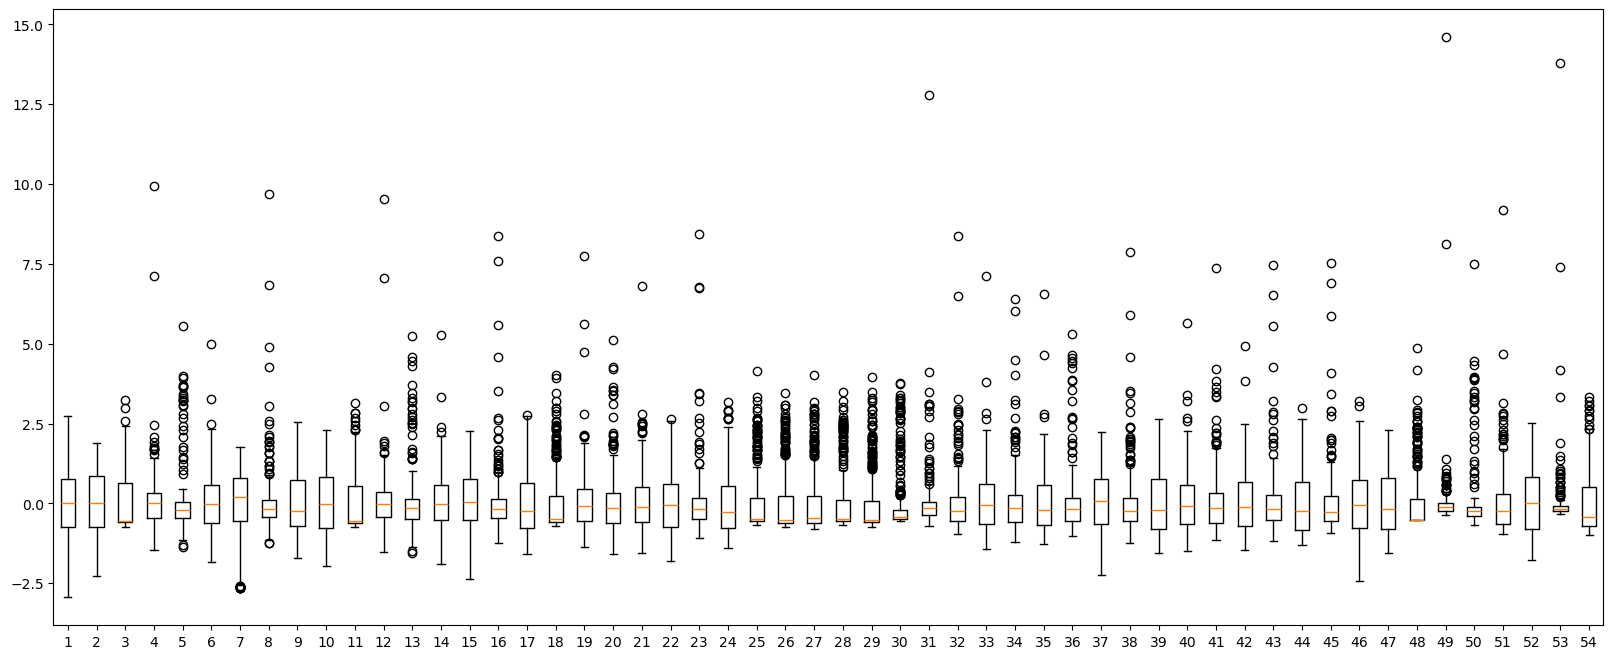

In [4]:
X_train_quad = x2fx(X_train)
X_val_quad = x2fx(X_val)
X_test_quad = x2fx(X_test)

X_train_std, X_mu, X_sigma = standardise(X_train)
X_val_std, _, _ = standardise(X_val, X_mu, X_sigma)
X_test_std, _, _ = standardise(X_test, X_mu, X_sigma)

X_train_quad_std, X_quad_mu, X_quad_sigma = standardise(X_train_quad[:,1:])
X_val_quad_std, _, _ = standardise(X_val_quad[:,1:], X_quad_mu, X_quad_sigma)
X_test_quad_std, _, _ = standardise(X_test_quad[:,1:], X_quad_mu, X_quad_sigma)

y_train_std, y_mu, y_sigma = standardise(y_train)
y_val_std, _, _ = standardise(y_val, y_mu, y_sigma)
y_test_std, _, _ = standardise(y_test, y_mu, y_sigma)

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train_quad_std);

### Step 2 (Question 1): Fit the Linear Model

Fit a linear model to your data. Fit a model to both the original (i.e. without higher order terms) and expanded versions of the data to observe how severe the overfitting is.

Be sure to evaluate the models on the validation and test sets. You should also consider qq-plots and $R^2$ values when inspecting the model's performance. To maximise code re-use, you may wish to write a function that takes a model, and various datasets (train, validation and test) as input, and calculates relevant performance measures. Some functions to compute performance measures are given below. Remember that $R^2$ should only be computed on the training set.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              779.8
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                   5.89e-198
Time:                        03:06:04   Log-Likelihood:                          57.853
No. Observations:                 300   AIC:                                     -97.71
Df Residuals:                     291   BIC:                                     -64.37
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

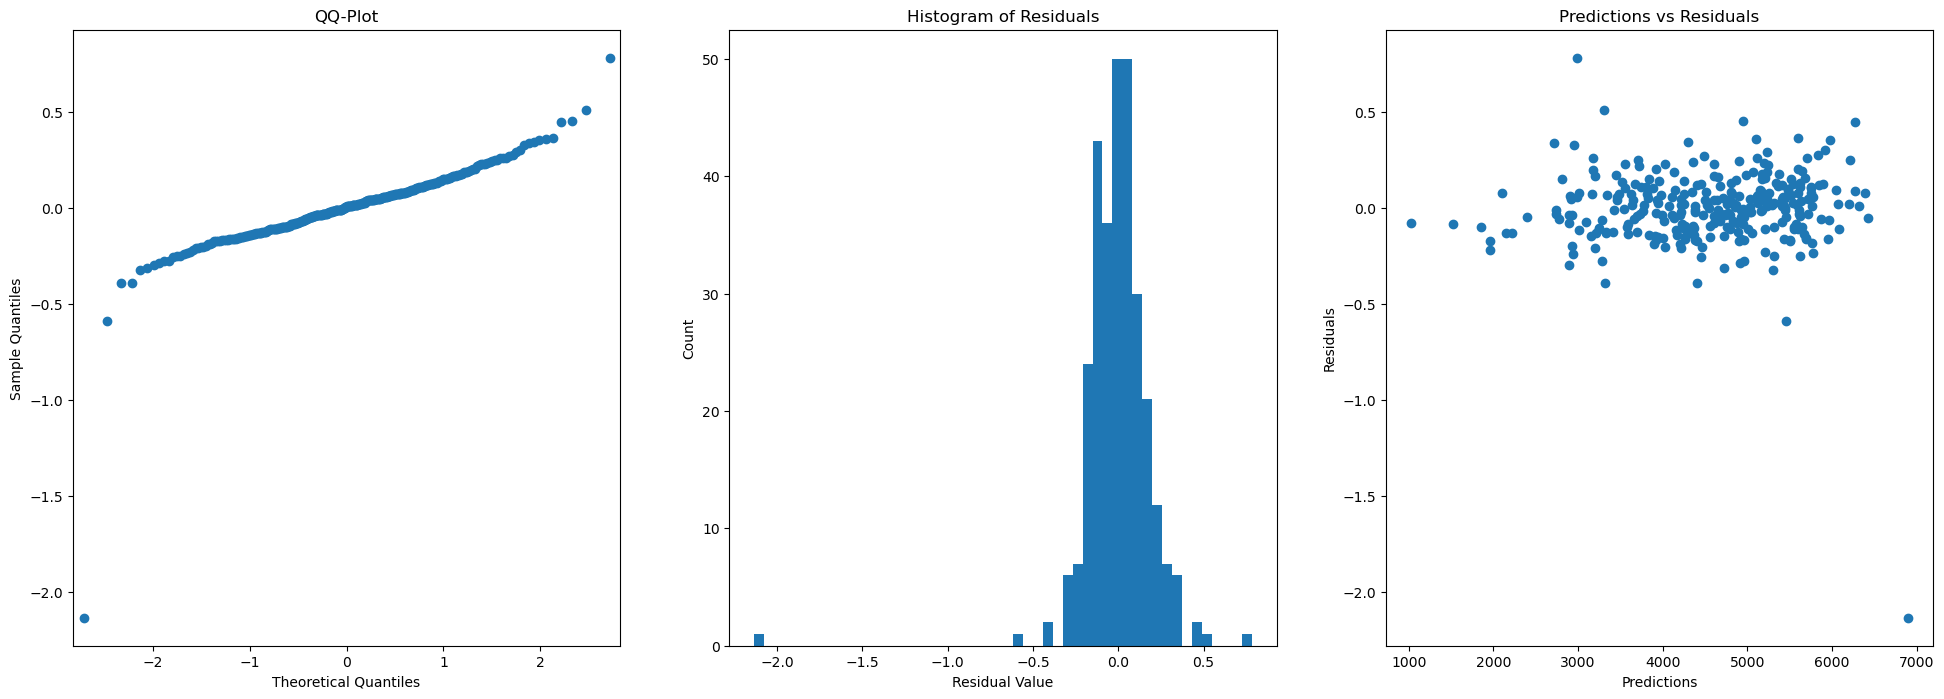

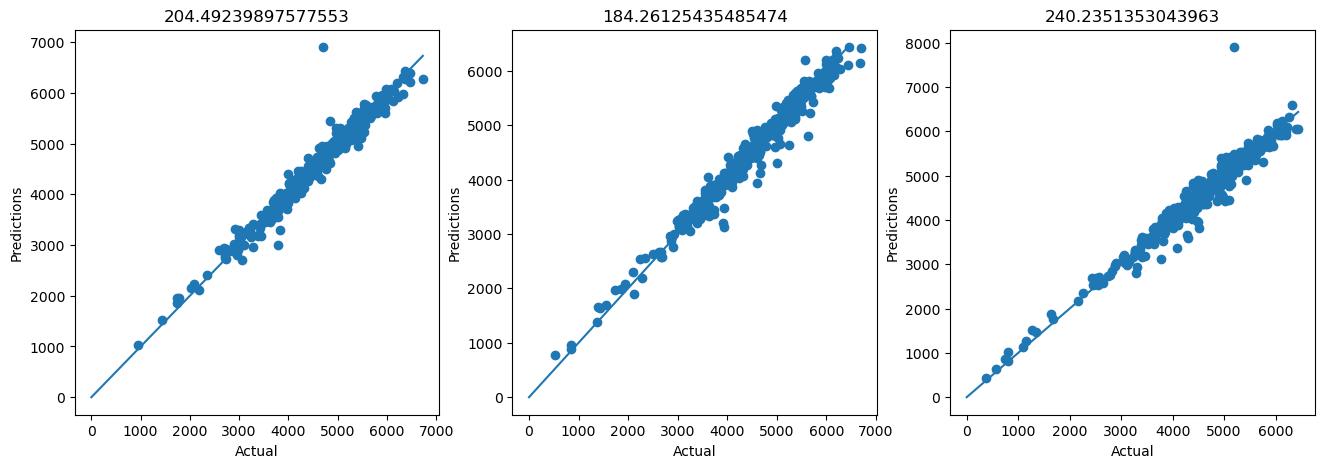

In [5]:
def rmse(actual, pred):
  return np.sqrt(mean_squared_error(actual, pred))

def r_squared(actual, predicted):
  r2 = r2_score(actual, predicted)
  return r2

def adj_r2(actual, predicted, n, p):
  r2 = r2_score(actual, predicted)
  adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1);
  return adjr2

def plot_diagnoistics(trained_model, resid, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mu = 0, Y_sigma = 1):

    # undo standardisation, multiply by sigma, add mu
    Y_train_pred = trained_model.predict(X_train)*Y_sigma + Y_mu
    Y_val_pred = trained_model.predict(X_val)*Y_sigma + Y_mu
    Y_test_pred = trained_model.predict(X_test)*Y_sigma + Y_mu
    
    # undo standardisation for testing data
    Y_train_scaled = Y_train*Y_sigma + Y_mu
    Y_val_scaled = Y_val*Y_sigma + Y_mu
    Y_test_scaled = Y_test*Y_sigma + Y_mu

    fig = plt.figure(figsize=[24, 8])
    ax = fig.add_subplot(1, 3, 1)
    f = sm.qqplot(resid, ax=ax)
    ax.set_title('QQ-Plot')    
    
    ax = fig.add_subplot(1, 3, 2)
    ax.hist(resid, 50)
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of Residuals')    

    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(Y_train_pred, resid)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Residuals')
    ax.set_title('Predictions vs Residuals')

    rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_scaled)**2))
    rmse_val = np.sqrt(np.mean((Y_val_pred - Y_val_scaled)**2))
    rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test_scaled)**2))

    fig = plt.figure(figsize=[16, 5])
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(Y_train_scaled, Y_train_pred)
    v = int(np.min([np.max(Y_train_scaled), np.max(Y_train_pred)]))
    ax.plot(np.arange(0, v))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predictions')
    ax.set_title(rmse_train)

    ax = fig.add_subplot(1, 3, 2)
    ax.scatter(Y_val_scaled, Y_val_pred)
    v = int(np.min([np.max(Y_val_scaled), np.max(Y_val_pred)]))
    ax.plot(np.arange(0, v))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predictions')
    ax.set_title(rmse_val)

    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(Y_test_scaled, Y_test_pred)
    v = int(np.min([np.max(Y_test_scaled), np.max(Y_test_pred)]))
    ax.plot(np.arange(0, v))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predictions')
    ax.set_title(rmse_test)

model_linear_simple = sm.OLS(y_train_std, X_train_std).fit()
print(model_linear_simple.summary())
plot_diagnoistics(model_linear_simple, model_linear_simple.resid, X_train_std, y_train_std, X_val_std, y_val_std, \
                  X_test_std, y_test_std, y_mu, y_sigma)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              341.9
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                   2.36e-203
Time:                        03:06:05   Log-Likelihood:                          224.01
No. Observations:                 300   AIC:                                     -340.0
Df Residuals:                     246   BIC:                                     -140.0
Df Model:                          54                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

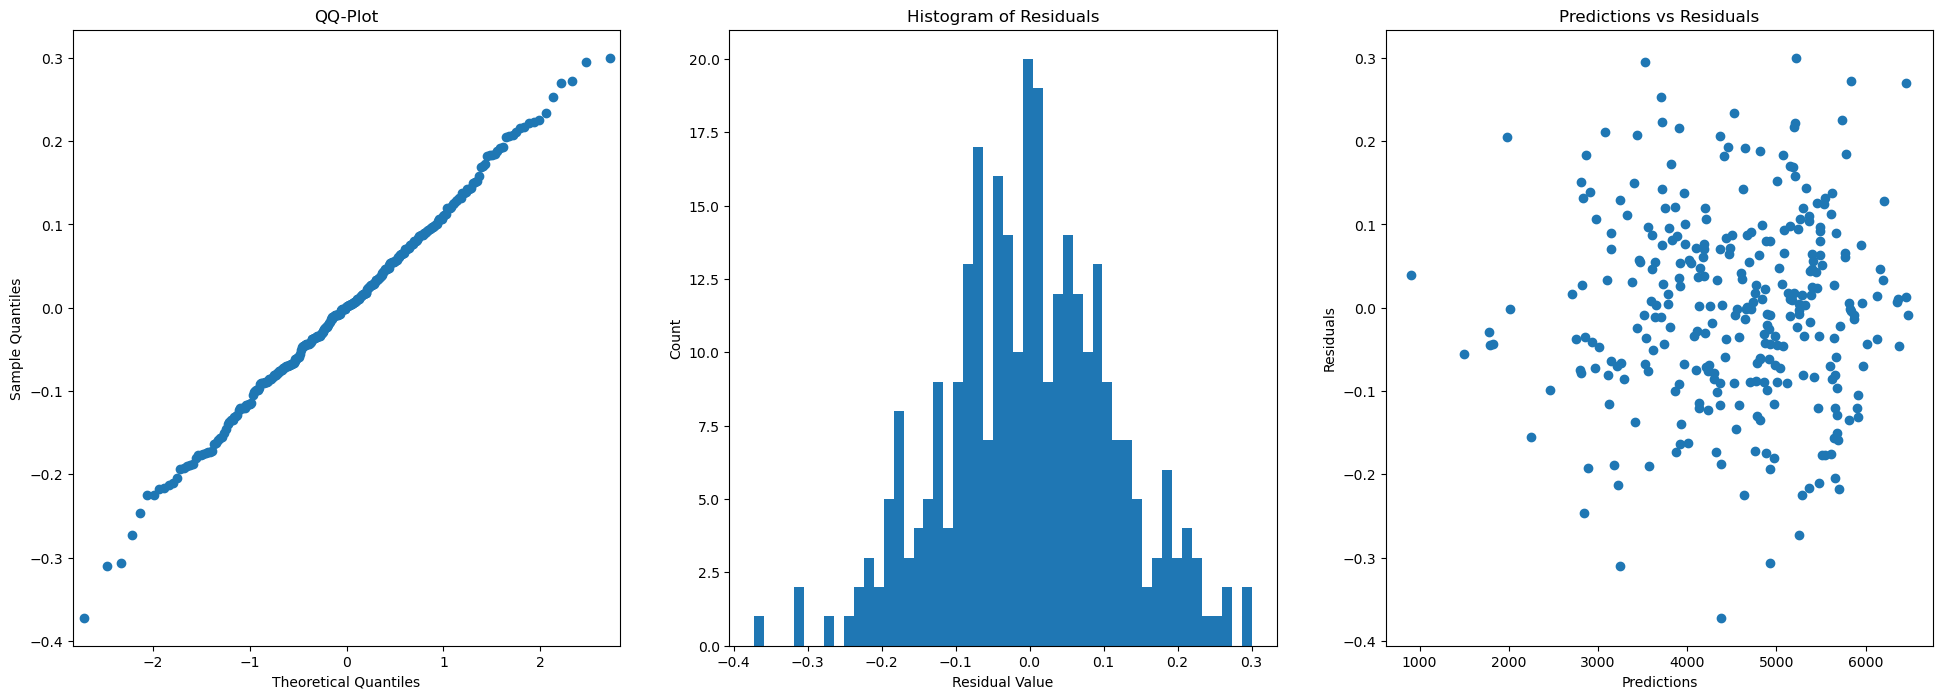

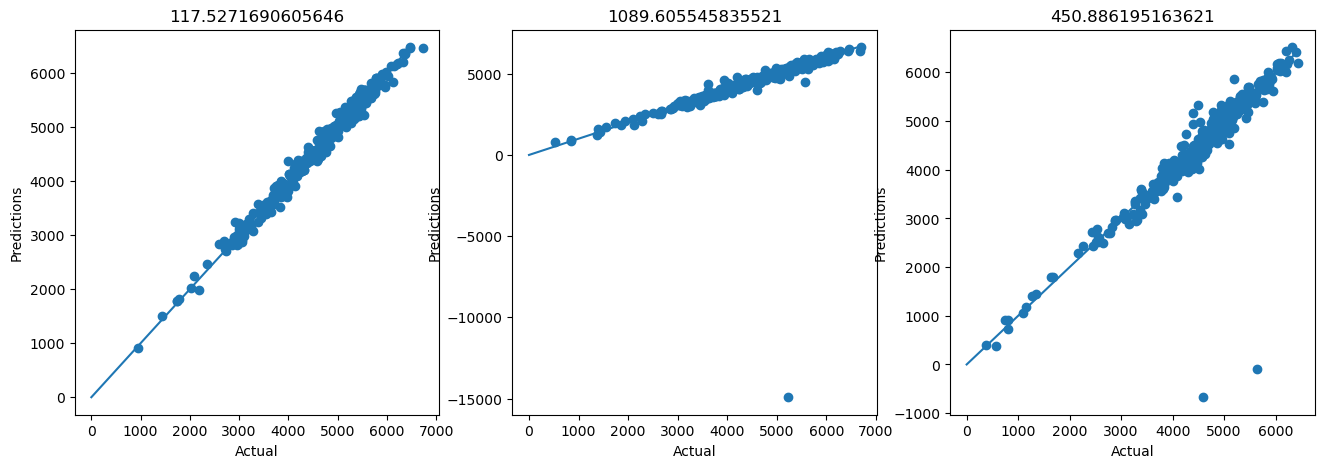

In [6]:
model_linear_quad = sm.OLS(y_train_std, X_train_quad_std).fit()
print(model_linear_quad.summary())
plot_diagnoistics(model_linear_quad, model_linear_quad.resid, X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, \
                  X_test_quad_std, y_test_std, y_mu, y_sigma)

### Step 3 (Question 2): Fit the Ridge Model

Fit a ridge model to your data.

It's recommended to use standardised data here, if you aren't already doing so.

The key consideration here is your value of $\lambda$. A good process to follow will be:
* Select a range of $\lambda$ values to consider. I would suggest using something like ``alpha_list = np.linspace(0, 10.0, 1000)``. Note that ``lambda`` is a keyword in python, hence we are calling this ``alpha`` here.
* Loop over the values of $\lambda$, i.e. ``for alpha in alpha_list:``
  * For each value of $\lambda$, fit a regression model
  * Get the RMSE on the validation set. You may also wish to compute:
    * RMSE on the training set
    * $R^$ on the training set
* Find the value of $\lambda$ that minimises the RMSE on the validation set

If your best value of $\lambda$ is $0$, you need to select a smaller step in your list of values, (i.e. in the above example we'd change this to ``alpha_list = np.linspace(0, 0.1, 10.0)``). If your best value is equal the maximum value in your range, then you need to search over a larger area (i.e. in the above example change it to ``alpha_list = np.linspace(0, 50.0, 10000)``). You may also want to refine your estimate, without making the search space huge. To do this, let's say the you get a value of $\lambda$ of 100, using the above ``linspace``. In this case you could search around the following: ``alpha_list = np.linspace(90.0, 0.1, 110.0)``.

Once you've found your value of $\lambda$, fit the final model, evaluate it as you did for the linear model, and compare the results.

In [7]:
def plot_rmses(lambdas, rmse_train, rmse_validation, log_scale = True):
    fig = plt.figure(figsize=[10, 4])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lambdas, rmse_train, label='Training RMSE')
    ax.plot(lambdas, rmse_validation, label='Validation RMSE')
    if log_scale:
        ax.set_xscale('log')
    ax.legend()

def plot_coeff(lambdas, coeffs, log_scale = True):
    fig = plt.figure(figsize=[10, 4])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(lambdas, coeffs);
    if log_scale:
        ax.set_xscale('log')
    
def find_lambda(lambdas, X_train, y_train, X_val, y_val, ridge, plot_stuff = True):

    rmse_train = []
    rmse_validation = []
    coeffs = []
    
    if (ridge):
        L1_wt = 0.0
    else:
        L1_wt = 1.0
    
    for l in lambdas:
        model = sm.OLS(y_train, X_train).fit_regularized(alpha=l, L1_wt=L1_wt)        
        coeffs.append(model.params)
        rmse_train.append(np.sqrt(np.mean((model.predict(X_train) - y_train)**2)))
        rmse_validation.append(np.sqrt(np.mean((model.predict(X_val) - y_val)**2)))
        
    if (plot_stuff):
        plot_rmses(lambdas, rmse_train, rmse_validation, True)
        plot_coeff(lambdas, coeffs, True)
    
    best_lambda_index = np.argmin(rmse_validation)
    return lambdas[best_lambda_index], best_lambda_index

2.782559402207126
7


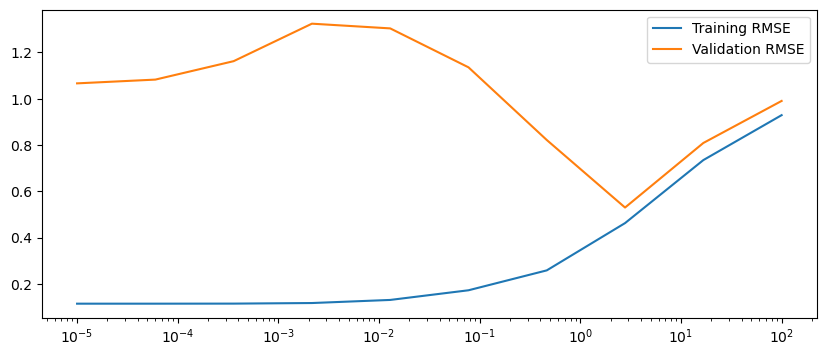

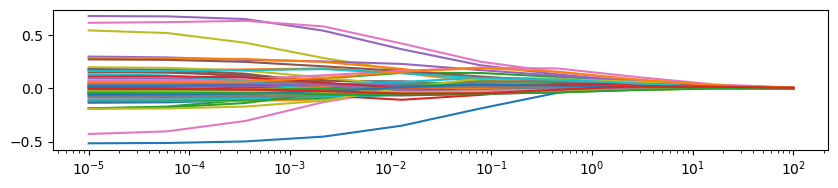

In [8]:
lambdas = np.logspace(-5, 2, 10)
best_lambda, best_lambda_index = find_lambda(lambdas, X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, True, True)
print(best_lambda)
print(best_lambda_index)

[1.00000000e-05 5.99484250e-05 3.59381366e-04 2.15443469e-03
 1.29154967e-02 7.74263683e-02 4.64158883e-01 2.78255940e+00
 1.66810054e+01 1.00000000e+02]
[ 0.46415888  0.69104475  1.02883488  1.53174046  2.28047172  3.39519089
  5.05479682  7.52563602 11.20424808 16.68100537]
2.280471722146734
4


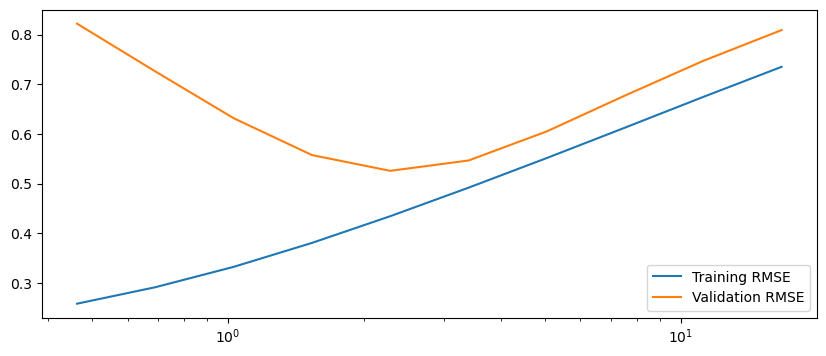

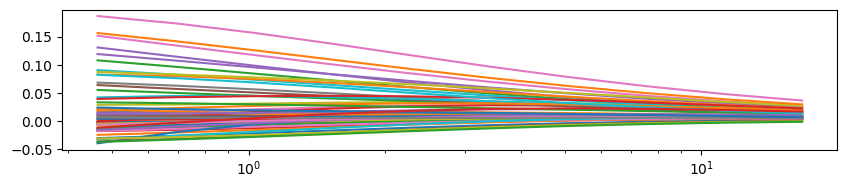

In [9]:
print(lambdas)
min_lambda = np.log10(lambdas[best_lambda_index - 1])
mmax_lambda = np.log10(lambdas[best_lambda_index + 1])
new_lambdas = np.logspace(min_lambda, mmax_lambda, 10)
print(new_lambdas)
best_lambda, best_lambda_index = find_lambda(new_lambdas, X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, True, True)
print(best_lambda)
print(best_lambda_index)

In [10]:
ridge_model = sm.OLS(y_train_std, X_train_quad_std).fit_regularized(alpha=best_lambda, L1_wt=0.0)

0.8112114023504386


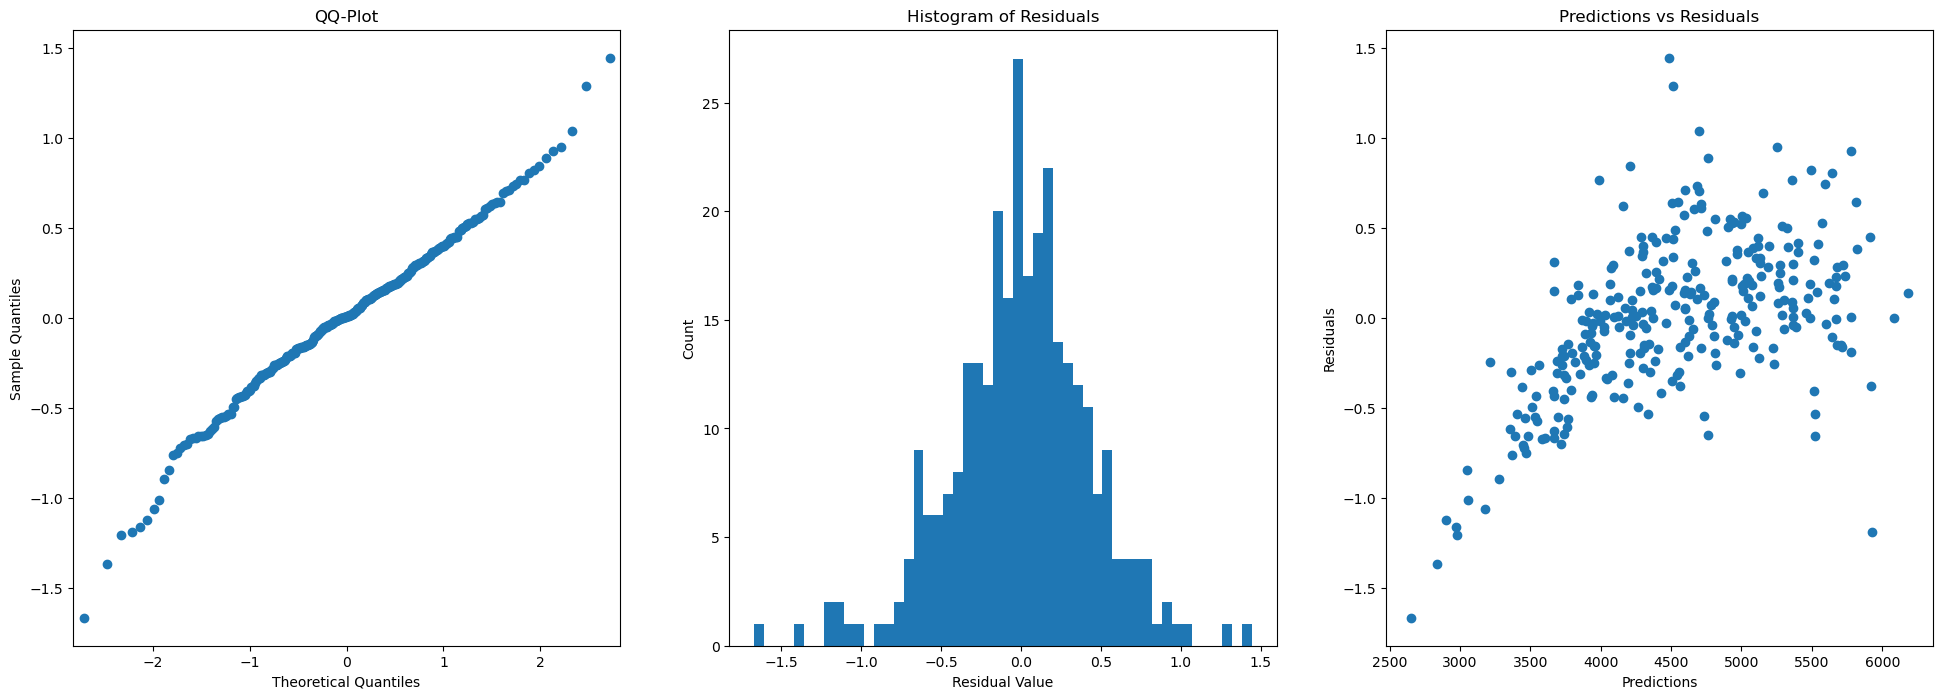

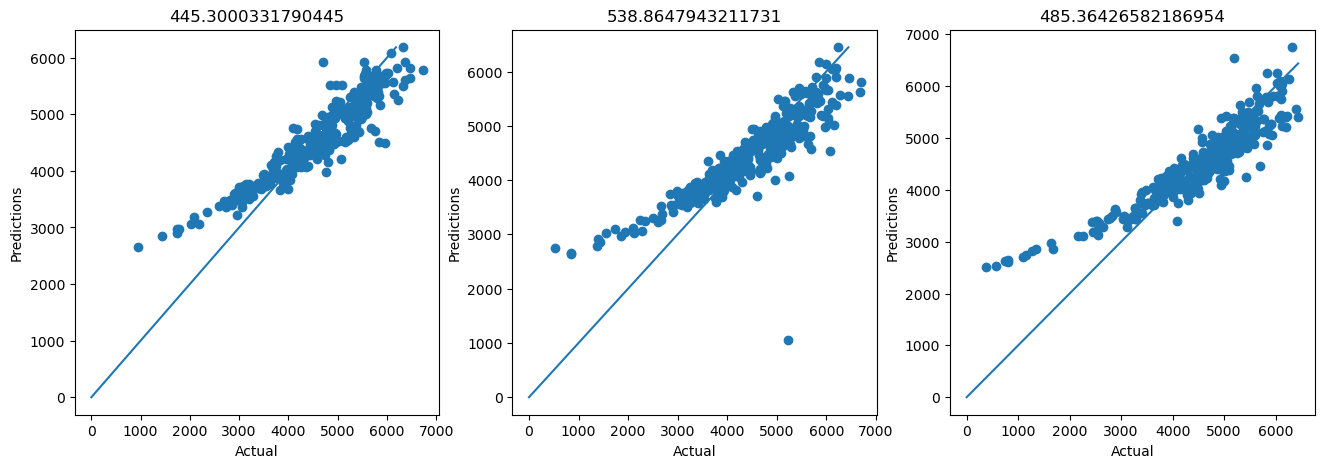

In [11]:
plot_diagnoistics(ridge_model, y_train_std - ridge_model.predict(X_train_quad_std), \
                  X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, X_test_quad_std, y_test_std, y_mu, y_sigma)
print(r_squared(y_train_std, ridge_model.predict(X_train_quad_std)))

### Step 4 (Question 3): Fit the LASSO Model

Fit a LASSO model to your data.

Your approach here should really follow what you've done for ridge. You should be able to copy and paste except:
* Change your range of $\lambda$ values. The same values that worked for Ridge will not be optimal here
* Change the regression function that you are calling. If you are using sklearn, this means swapping ``sklearn.linear_model.Ridge`` for ``sklearn.linear_model.Lasso``. If you are using statsmodels, this means that when you call ``fit_regularized`` you pass in ``L1_wt=1``.

Notes regarding $\lambda$ values as the same as for Ridge regression.

Once you have your final value of $\lambda$, evaluate the model and compare to the others.

0.01291549665014884
4


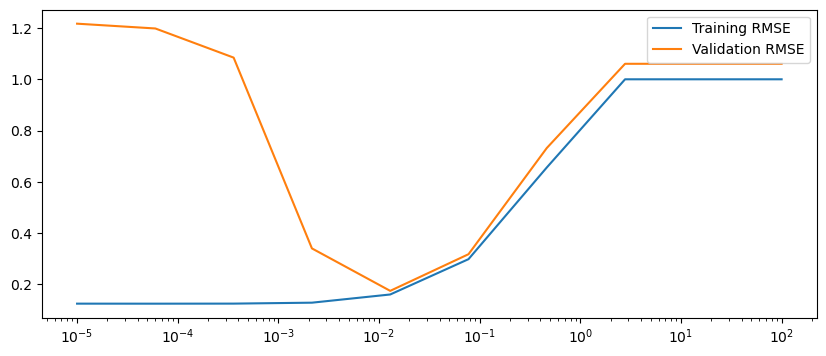

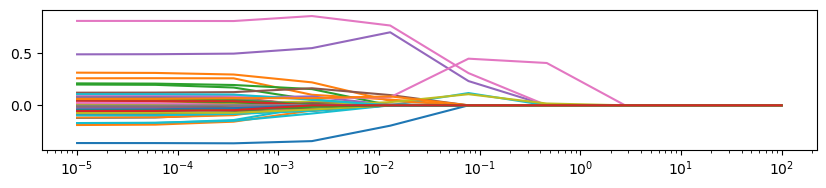

In [14]:
lambdas = np.logspace(-5, 2, 10)
best_lambda, best_lambda_index = find_lambda(lambdas, X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, False, True)
print(best_lambda)
print(best_lambda_index)

[1.00000000e-05 5.99484250e-05 3.59381366e-04 2.15443469e-03
 1.29154967e-02 7.74263683e-02 4.64158883e-01 2.78255940e+00
 1.66810054e+01 1.00000000e+02]
[0.00215443 0.00320755 0.00477543 0.00710971 0.01058501 0.01575908
 0.02346229 0.03493091 0.05200551 0.07742637]
0.007109709432312438
3


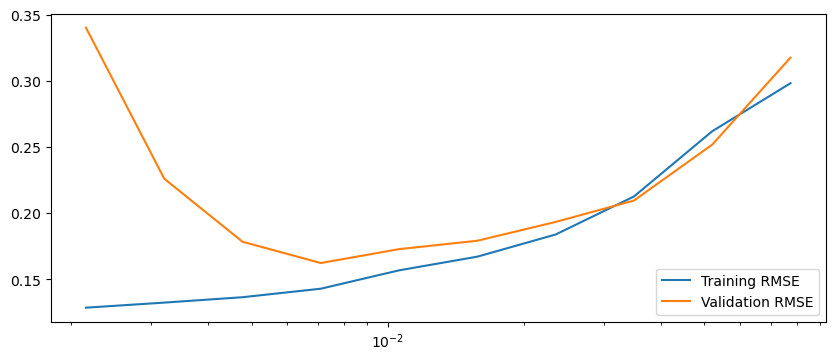

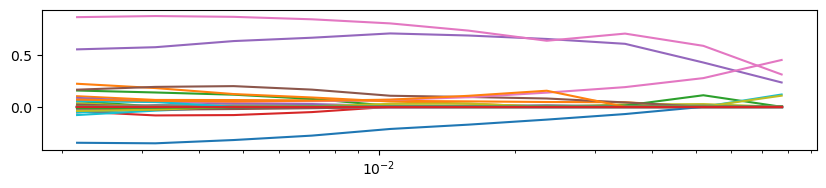

In [15]:
print(lambdas)
min_lambda = np.log10(lambdas[best_lambda_index - 1])
mmax_lambda = np.log10(lambdas[best_lambda_index + 1])
new_lambdas = np.logspace(min_lambda, mmax_lambda, 10)
print(new_lambdas)
best_lambda, best_lambda_index = find_lambda(new_lambdas, X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, False, True)
print(best_lambda)
print(best_lambda_index)

In [16]:
lasso_model = sm.OLS(y_train_std, X_train_quad_std).fit_regularized(alpha=best_lambda, L1_wt=1.0)

0.9795800366236362


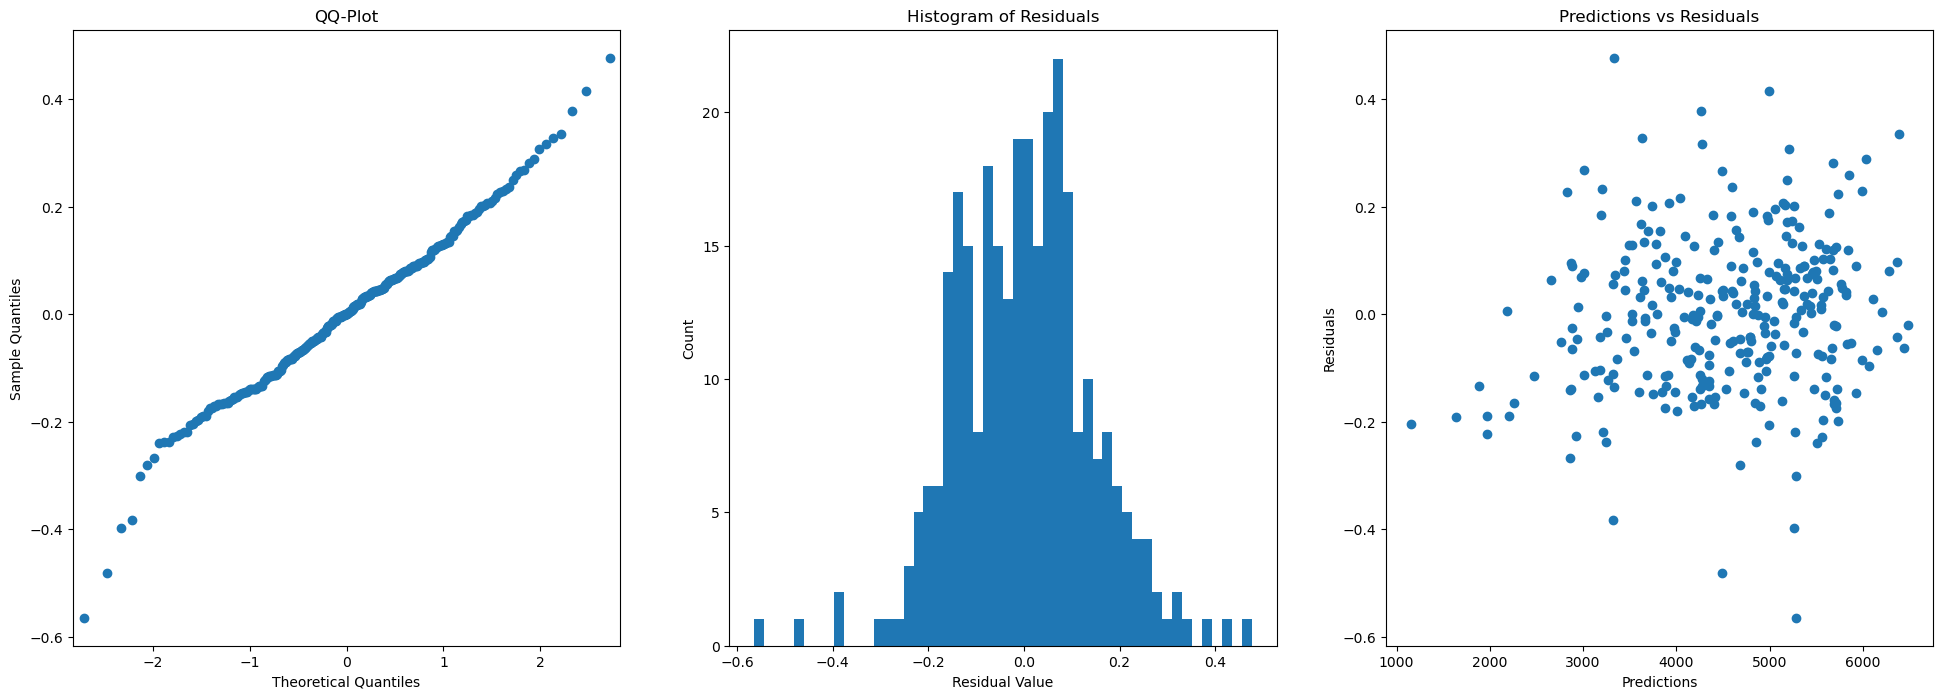

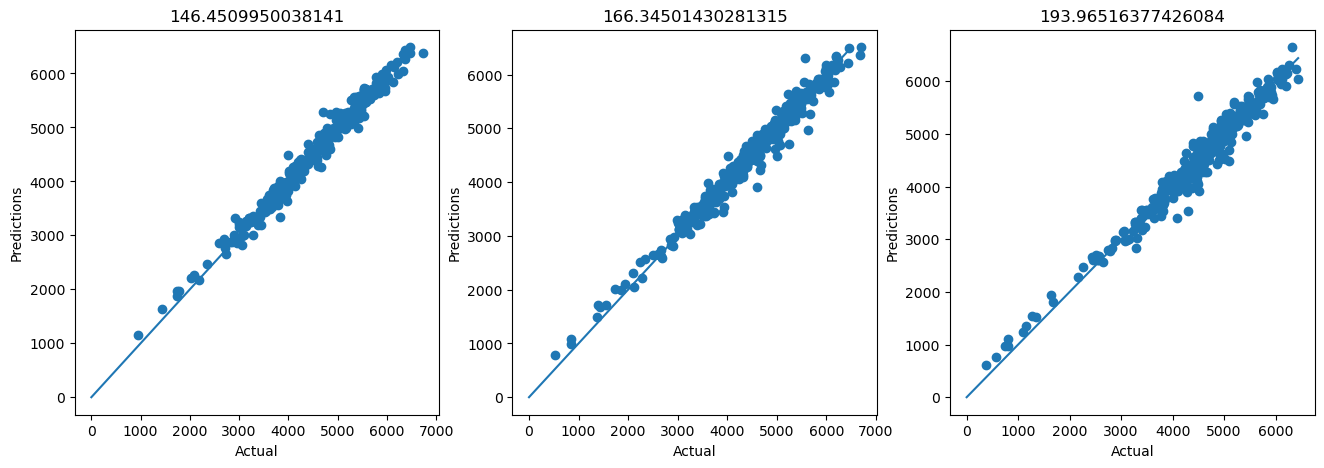

In [17]:
plot_diagnoistics(lasso_model, y_train_std - lasso_model.predict(X_train_quad_std), \
                  X_train_quad_std, y_train_std, X_val_quad_std, y_val_std, X_test_quad_std, y_test_std, y_mu, y_sigma)
print(r_squared(y_train_std, lasso_model.predict(X_train_quad_std)))

In [20]:
np.sum(lasso_model.params == 0)

38